**Import Library**

In [72]:
import re
import pandas as pd
import nltk
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

<h1>Baca Data<h1>

In [73]:
df = pd.read_csv("data.csv")
texts = df["full_text"].astype(str)
texts.to_csv("data.csv", index=False)

<h1>Membersihkan Data yang Kurang Relevant dan Hpus Duplikat</h1>

In [74]:
# Daftar kata kunci relevan dan tidak relevan untuk Fish It
topic_keywords = [
    "fish it", "fishit", "fishing", "roblox", "fish", "rod", "bait", "boat", "merchant",
    "secret", "ancient whale", "megalodon", "island", "jungle", "coral reef", "stingray shores",
    "kohana", "mutation", "shiny", "potion", "luck", "enchant", "battlepass", "admin event",
    "halloween event", "update", "f2p", "skin", "crab", "lobster"
]

irrelevant_keywords = [
    "download", "promo", "iklan", "klik link", "aplikasi", "follow", 
    "giveaway", "voucher", "diskon", "gratis", "registrasi", "daftar", "event", "joki"
]

# Fungsi untuk mengecek relevansi
def is_relevant(text):
    text_lower = text.lower()
    if any(bad in text_lower for bad in irrelevant_keywords):
        return False
    return any(topic in text_lower for topic in topic_keywords)

# Load data dari data.csv
df = pd.read_csv("data.csv")

# Langkah 1: Hapus duplikat berdasarkan teks asli
df = df.drop_duplicates(subset="full_text").reset_index(drop=True)

# Langkah 2: Filter data relevan
mask = df["full_text"].astype(str).apply(is_relevant)
df = df[mask].reset_index(drop=True)

# Simpan teks yang sudah difilter
texts = df["full_text"].astype(str)

# Cetak jumlah data setelah deduplikasi dan pembersihan topik
print(f"Jumlah data setelah deduplikasi dan pembersihan topik: {len(df)} baris tersisa.")

# Simpan hasil ke file CSV
texts.to_csv("deduplicated_fishit_data.csv", index=False)

Jumlah data setelah deduplikasi dan pembersihan topik: 1370 baris tersisa.


<h1>PraPemrosesan import Stemmer dari Sastrawi</h1>

In [75]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_nltk = set(stopwords.words('indonesian'))
stop_sastrawi = set(StopWordRemoverFactory().get_stop_words())
stop_words = stop_nltk.union(stop_sastrawi)


tokenizer = RegexpTokenizer(r'\w+')

Stemmer dari Sastrawi untuk mereduksi kata-kata Indonesia ke bentuk dasar. Kode menggabungkan daftar stopwords dari NLTK dan Sastrawi ke dalam satu himpunan stop_words untuk memfilter kata-kata umum. Selain itu, RegexpTokenizer dengan pola r'\w+' digunakan untuk memisahkan teks menjadi token alfanumerik, menghilangkan tanda baca. Pengaturan ini mendukung pra-pemrosesan teks untuk analisis seperti sentimen

<h1>Normalisasi Data</h1>

In [76]:
# Kamus untuk perbaikan typo, singkatan, dan kata gaul
corrections = {
    "anjir": "anjing", "anjg": "anjing", "anj": "anjing", "jir": "anjing", "bjir": "anjing",
    "ajg": "anjing", "anjay": "anjing", "shibal": "sial", "babii": "babi", "babi": "babi",
    "cok": "anjing", "cokk": "anjing", "coy": "coy", "cokkk": "anjing", "anjirr": "anjing",
    "anjirrr": "anjing", "anjrit": "anjing", "wtf": "apa", "lol": "tertawa", "wkwk": "tertawa",
    "wkwkwk": "tertawa", "haha": "tertawa", "hahaha": "tertawa", "hehe": "tertawa",
    "huhu": "sedih", "hiks": "sedih", "ckck": "ckck", "ckckck": "ckck", "gw": "gue",
    "gua": "gue", "ak": "aku", "aq": "aku", "w": "aku", "ku": "aku", "lu": "kamu",
    "loe": "kamu", "km": "kamu", "kmu": "kamu", "nder": "sender", "gak": "tidak",
    "ga": "tidak", "gk": "tidak", "ngga": "tidak", "bgt": "banget", "bgtt": "banget",
    "bngt": "banget", "bangett": "banget", "bangettt": "banget", "sih": "sih", "nih": "ini",
    "yah": "ya", "yaah": "ya", "yaa": "ya", "yh": "ya", "pls": "tolong", "plis": "tolong",
    "pliss": "tolong", "dm": "dm", "dmn": "dimana", "dmana": "dimana", "brp": "berapa",
    "brpa": "berapa", "tp": "tapi", "tpi": "tapi", "tpii": "tapi", "sm": "sama",
    "sma": "sama", "smpe": "sampai", "sampe": "sampai", "ampe": "sampai", "lg": "lagi",
    "lgi": "lagi", "udh": "sudah", "udah": "sudah", "dah": "sudah", "sdh": "sudah",
    "blm": "belum", "blom": "belum", "bkn": "bukan", "bukan": "bukan", "gkda": "tidak ada",
    "gada": "tidak ada", "gaada": "tidak ada", "klo": "kalau", "kalo": "kalau", "kl": "kalau",
    "kek": "seperti", "kyk": "seperti", "kayak": "seperti", "gt": "gitu", "gtu": "gitu",
    "gini": "begini", "gmn": "bagaimana", "gimana": "bagaimana", "aj": "aja", "aja": "aja",
    "ajah": "aja", "nih": "ini", "ni": "ini", "nih": "ini", "mah": "mah", "dong": "dong",
    "dng": "dengan", "dgn": "dengan", "bs": "bisa", "bisa": "bisa", "co": "checkout", "bsa": "bisa",
    "bgtu": "begitu", "bgini": "begini", "nih": "ini", "sbg": "sebagai", "trs": "terus",
    "terus": "terus", "dll": "dan lain-lain", "yg": "yang", "yng": "yang", "dr": "dari",
    "pd": "pada", "dri": "dari", "kmrn": "kemarin", "kmarin": "kemarin", "skrg": "sekarang",
    "skg": "sekarang", "bnyk": "banyak", "bnyak": "banyak", "bang": "bang", "kak": "kak",
    "kk": "kakak", "nder": "sender", "roblox": "roblox", "fish it": "fish it", "fishit": "fish it",
    "tai": "kotoran", "anjing": "anjing", "sial": "sial", "babi": "babi", "cok": "anjing",
    "jancok": "anjing", "puki": "alat kelamin", "memek": "alat kelamin", "kontol": "alat kelamin",
    "pepek": "alat kelamin", "tolol": "bodoh", "goblok": "bodoh", "gblk": "bodoh", "bodoh": "bodoh",
    "stress": "stres", "stres": "stres", "capek": "capek", "cape": "capek", "penat": "penat",
    "iri": "iri", "dengki": "dengki", "hoki": "beruntung", "luck": "keberuntungan", "rng": "random",
    "afk": "afk", "joki": "joki", "wtb": "want to buy", "wts": "want to sell", "wta": "want to ask",
    "wtt": "want to trade", "zonauang": "zona uang", "zonajajan": "zona jajan", "zonaba": "zona barang",
    "robux": "robux", "rbx": "robux", "gacha": "gacha", "enchant": "enchant", "stone": "batu",
    "sikrit": "secret", "scret": "secret", "secrete": "secret", "secret": "secret", "mitos": "mitos",
    "mitik": "mitos", "mythic": "mitos", "legendary": "legenda", "lagendary": "legenda", "talon": "talon",
    "kikir": "kikir", "pensi": "pensiun", "pensiun": "pensiun", "ngekost": "ngekost", "nginep": "menginap",
    "ngabisin": "menghabiskan", "nabung": "menabung", "nugas": "ngerjain tugas", "ngerjain": "mengerjakan",
    "mabar": "main bareng", "mutualan": "mutual", "add": "add", "follback": "follow back", "dm": "direct message",
    "wa": "whatsapp", "gc": "group chat", "dc": "discord", "vd": "vd", "gag": "gag", "fisch": "fisch",
    "fishch": "fisch", "f2p": "free to play", "update": "update", "event": "event", "admin": "admin",
    "boost": "boost", "luck": "luck", "x8": "x8", "ps": "private server", "pubser": "public server",
    "server": "server", "cuaca": "cuaca", "weather": "cuaca", "mega": "megalodon", "kraken": "kraken",
    "worm": "worm", "scare": "scare", "ghost": "ghost", "shark": "shark", "whale": "whale", "sotong": "sotong",
    "ikan": "ikan", "pancing": "pancing", "pancingan": "pancingan", "rod": "pancingan", "bait": "umpan",
    "boat": "perahu", "island": "pulau", "jungle": "jungle", "lost": "lost", "isle": "isle", "volcano": "volcano",
    "antartika": "antartika", "gunung": "gunung", "muncak": "mendaki", "naik": "naik", "panjat": "panjat",
    "roblox_fess": "roblox fess", "txtFromRoblox": "txt from roblox", "roblox": "roblox"
}

# Daftar kata/frasa yang akan disaring
unwanted_phrases = [
    'checkout', 'Checkout', 'CHECKOUT',
    'want sell', 'Want Sell', 'WANT SELL', 'want to sell', 'Want to Sell',
    'want buy', 'Want Buy', 'WANT BUY', 'want to buy', 'Want to Buy',
    'roblox fess', 'Roblox Fess', 'ROBLOX FESS', 'roblox_fess', 'Roblox_Fess'
]

# Fungsi untuk mengurangi huruf berulang
def reduce_repeated_letters(word):
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

# Fungsi normalisasi teks
def normalize_text(text):
    # Lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    normalized_tokens = []
    for token in tokens:
        # Kurangi huruf berulang
        token = reduce_repeated_letters(token)
        
        # Perbaiki dengan kamus
        if token in corrections:
            token = corrections[token]
        
        # Hapus jika kurang dari 3 huruf
        if len(token) >= 3:
            normalized_tokens.append(token)
    
    # Gabung kembali jadi string
    normalized_text = ' '.join(normalized_tokens)
    
    return normalized_text

# Fungsi untuk menghapus kata/frasa yang tidak diinginkan
def remove_unwanted_phrases(text):
    for phrase in unwanted_phrases:
        text = re.sub(r'\b' + re.escape(phrase) + r'\b', '', text, flags=re.IGNORECASE)
    return ' '.join(text.split())  # Hilangkan spasi berlebih

# Fungsi untuk memeriksa relevansi (contoh, harus didefinisikan sesuai kebutuhan)
def is_relevant(text):
    # Contoh: anggap semua teks relevan kecuali yang mengandung kata tertentu
    # Sesuaikan dengan kebutuhan spesifik Anda
    return True

# Load data dari data.csv
try:
    df = pd.read_csv("data.csv")
except FileNotFoundError:
    print("File 'data.csv' tidak ditemukan. Pastikan file ada di direktori yang sama.")
    exit()

# Langkah 1: Filter data relevan
mask = df["full_text"].astype(str).apply(is_relevant)
df = df[mask].reset_index(drop=True)

# Langkah 2: Normalisasi teks
df["normalized_text"] = df["full_text"].apply(normalize_text)

# Langkah 3: Saring frasa yang tidak diinginkan
df["filtered_text"] = df["normalized_text"].apply(remove_unwanted_phrases)

# Langkah 4: Simpan teks yang sudah dinormalisasi dan disaring
texts = df["filtered_text"].astype(str)

# Cetak jumlah data setelah pembersihan topik, normalisasi, dan penyaringan
print(f"Jumlah data setelah pembersihan topik, normalisasi, dan penyaringan: {len(df)} baris tersisa.")

Jumlah data setelah pembersihan topik, normalisasi, dan penyaringan: 1372 baris tersisa.


Corrections yang berisi pasangan kata atau frasa yang sering digunakan dalam bahasa gaul, singkatan, atau typo ("wtb" menjadi "want to buy"). Kamus ini mencakup berbagai istilah informal, khususnya yang terkait dengan komunitas online seperti Roblox, serta kata-kata umum dalam bahasa Indonesia. Kamus ini digunakan untuk menormalkan teks agar lebih konsisten dan mudah dianalisis, misalnya untuk analisis sentimen atau pembuatan word cloud.

Fungsi reduce_repeated_letters menggunakan ekspresi reguler (re.sub) untuk mengurangi huruf yang berulang lebih dari dua kali dalam sebuah kata menjadi dua huruf saja (misalnya, "anjirrr" menjadi "anjirr"). Ini membantu menangani variasi penulisan kata gaul yang sering kali menggunakan pengulangan huruf untuk ekspresi emosional.

Fungsi normalize_text melakukan beberapa langkah untuk menormalkan teks. Pertama, teks diubah menjadi huruf kecil (case folding) untuk konsistensi. Kemudian, teks ditokenisasi menggunakan word_tokenize dari NLTK untuk memisahkan kata-kata. Setiap token diproses dengan mengurangi huruf berulang (menggunakan reduce_repeated_letters), lalu diperiksa terhadap kamus corrections untuk mengganti kata gaul atau typo dengan bentuk standar. Token dengan panjang kurang dari tiga huruf dihapus, dan token yang tersisa digabung kembali menjadi string untuk menghasilkan teks yang telah dinormalisasi.

Memproses teks penyaringan frasa yang tidak diinginkan seperti "checkout", "want sell", "want buy", dan "roblox fess" menggunakan regex case-insensitive untuk memastikan penghapusan kata yang tepat.

<h1>Pembersihan data menggunakan case folding CPMK 2<h1>

In [77]:
def case_folding(text):
    text = text.lower()
    return text

df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding": texts.apply(case_folding)
})

df_new.to_csv("data_casefolding.csv", index=False)

Mengubah teks menjadi huruf kecil untuk standardisasi. Fungsi tersebut diterapkan pada daftar teks dalam variabel texts untuk membuat kolom baru bernama case_folding. Kode kemudian membuat DataFrame baru df_new menggunakan pandas, yang berisi kolom full_text (teks asli) dan case_folding (teks setelah konversi huruf kecil). Terakhir, DataFrame ini disimpan ke file CSV bernama data_casefolding.csv

<h1>Preprocessing regex, tokenisasi dan pemakaian stemmer CPMK 3<h1>

In [78]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = emoji.demojize(text)
    text = re.sub(r'\d+',' ', text)
    text = re.sub(r'[^\w\s]',' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+',' ', text).strip()
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

df["preprocessing"] = texts.apply(clean_text)

df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding CPMK2": texts.apply(case_folding),
    "preprocessing CPMK3": df["preprocessing"]
})

df_new.to_csv("data_prepocessing.csv", index=False)

Preprocessing teks dengan fungsi clean_text untuk membersihkan dan menstandarisasi data teks agar lebih mudah dianalisis. Proses ini melibatkan beberapa langkah: mengubah teks menjadi huruf kecil (case folding), menghapus URL (dengan pola http\S+|www\S+), menghapus mention seperti @username, mengonversi emoji menjadi representasi teks menggunakan emoji.demojize, menghapus angka, menghapus tanda baca dan karakter khusus, mengurangi karakter berulang (misalnya "aaa" menjadi "a"), serta menghapus spasi berlebih untuk menghasilkan teks yang bersih dan terstandar. Hasilnya adalah teks yang lebih konsisten dan siap untuk tahap analisis berikutnya, seperti tokenisasi.

Tokenisasi dengan memanggil tokenizer.tokenize(text), yang memecah teks yang telah dibersihkan menjadi unit-unit kecil yang disebut token (biasanya kata-kata individual). Proses ini penting karena memungkinkan analisis teks pada tingkat kata, bukan sebagai satu string panjang. Tokenisasi memisahkan teks berdasarkan spasi atau aturan tertentu yang ditentukan oleh tokenizer yang digunakan (misalnya, library seperti NLTK atau spaCy). Tokenisasi menghasilkan daftar kata-kata yang kemudian akan diproses lebih lanjut, seperti menghapus stop words dan melakukan stemming untuk analisis teks yang lebih mendalam.

Stemming dilakukan dengan menggunakan stemmer.stem(w) pada setiap token setelah tokenisasi dan penghapusan stop words. Stemming adalah proses mengurangi kata ke bentuk dasarnya atau akarnya (stem) dengan menghapus imbuhan, seperti mengubah "berlari" menjadi "lari" atau "running" menjadi "run". Tujuannya adalah untuk menyatukan variasi kata yang memiliki makna serupa agar analisis teks lebih efisien, misalnya dalam text mining atau klasifikasi teks. Stemming diterapkan pada setiap token untuk menghasilkan daftar kata-kata dalam bentuk dasar yang kemudian digabung kembali menjadi string dengan spasi sebagai pemisah untuk disimpan dalam kolom "preprocessing".

In [79]:
df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding CPMK2": texts.apply(case_folding),
    "preprocessing CPMK3": df["preprocessing"]
})

df_new.to_csv("data.csv", index=False)

<h1>N-Gram CPMK 4</h1>

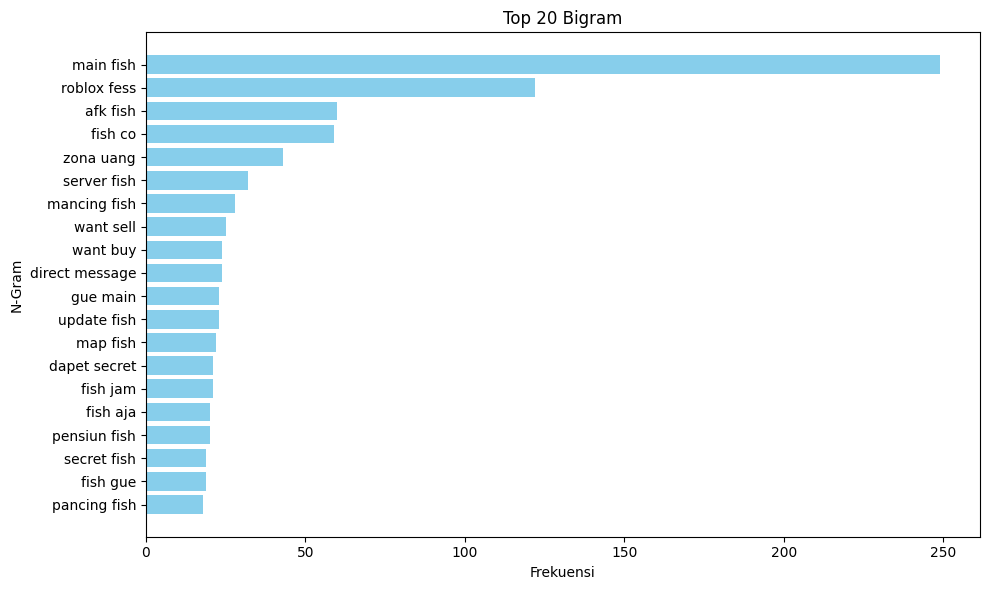

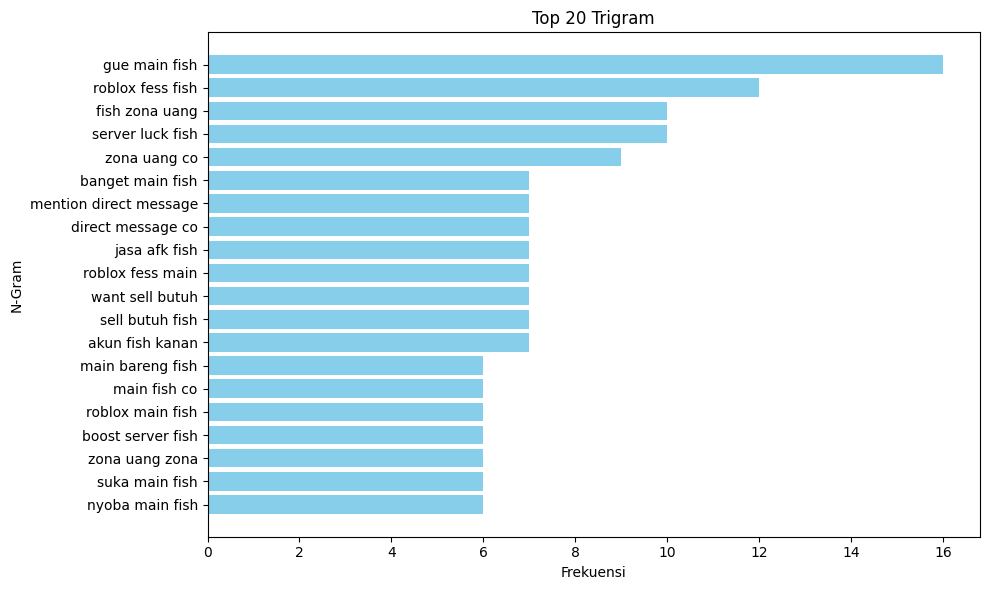

In [80]:
# Fungsi untuk plot top N-grams
def plot_top_ngrams(corpus, ngram_range=(2, 2), top_n=20, title="Top N-Grams"):
    try:
        # Inisialisasi CountVectorizer
        vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        
        # Ambil frekuensi kata
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

        # Buat DataFrame untuk visualisasi
        ngram_df = pd.DataFrame(words_freq, columns=['NGram', 'Count'])

        # Plot horizontal bar
        plt.figure(figsize=(10, 6))
        plt.barh(ngram_df['NGram'][::-1], ngram_df['Count'][::-1], color='skyblue')
        plt.title(title)
        plt.xlabel("Frekuensi")
        plt.ylabel("N-Gram")
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Error saat memproses N-Grams: {e}. Pastikan corpus tidak kosong atau berisi teks yang valid.")

# Plot bigram dan trigram
plot_top_ngrams(corpus, ngram_range=(2, 2), title="Top 20 Bigram")
plot_top_ngrams(corpus, ngram_range=(3, 3), title="Top 20 Trigram")

Fungsi plot_top_ngrams untuk menghasilkan visualisasi horizontal bar chart dari N-gram (bigram atau trigram) teratas berdasarkan frekuensi kemunculan dalam korpus teks, menggunakan CountVectorizer dari pustaka scikit-learn untuk menghitung frekuensi N-gram. Fungsi ini mengambil parameter corpus (kumpulan teks), ngram_range (misalnya, (2, 2) untuk bigram atau (3, 3) untuk trigram), top_n (jumlah N-gram teratas, default 20), dan title untuk judul plot. CountVectorizer mengubah korpus menjadi matriks frekuensi, lalu kode menghitung jumlah kemunculan setiap N-gram, mengurutkannya, dan menyimpan top_n N-gram ke dalam DataFrame pandas. 

<h1>WorldCloud CPMK 4</h1>

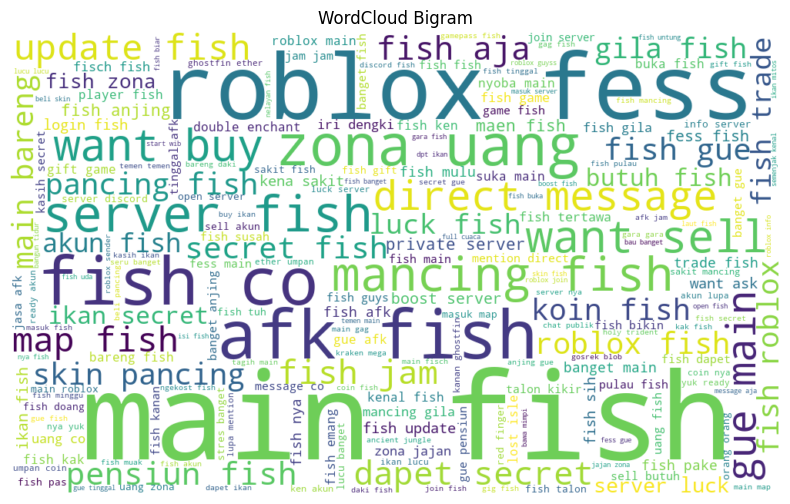

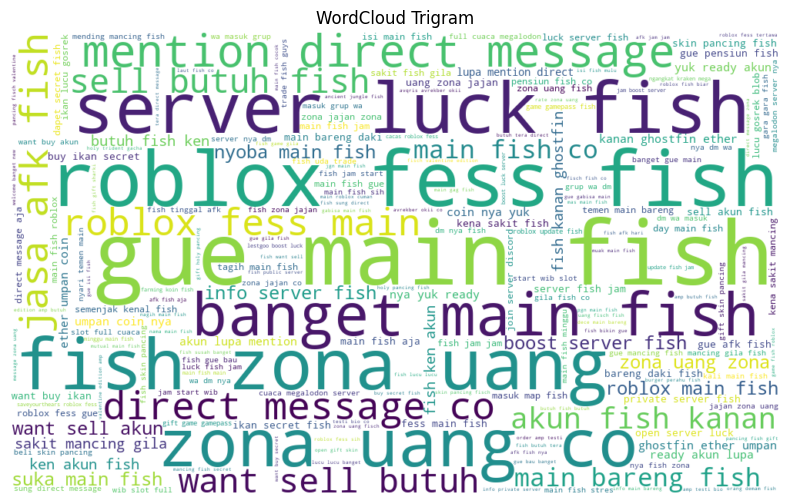

In [81]:
def generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram"):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    freq_dict = dict(words_freq)
    
    plt.figure(figsize=(10,6))
    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(freq_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_ngram_wordcloud(corpus, ngram_range=(2,2), title="WordCloud Bigram")
generate_ngram_wordcloud(corpus, ngram_range=(3,3), title="WordCloud Trigram")


Fungsi generate_ngram_wordcloud untuk membuat word cloud berdasarkan frekuensi N-gram (bigram atau trigram) dari korpus teks, menggunakan CountVectorizer dari scikit-learn untuk menghitung frekuensi N-gram dan pustaka wordcloud untuk visualisasi. Fungsi ini mengambil parameter corpus (kumpulan teks), ngram_range (misalnya, (2,2) untuk bigram atau (3,3) untuk trigram), dan title untuk judul word cloud.